In [1]:
import torch
import torch.nn.functional as F
import matplotlib 
%matplotlib inline 

In [2]:
words = open('names.txt' , 'r').read().splitlines()

In [3]:
# Building the vocabulary
chars = (sorted(list(set(''.join(words)))))
stoi =  {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(stoi)

In [4]:
block_size = 3 # No. of characters we want to provide as context

def build_dataset(words):

    X = []
    Y = []
    for w in words :
        context = [0] * block_size

        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
            

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print (X.shape , Y.shape)
    
    return X , Y

import random 
random.seed(47)
random.shuffle(words)

# train , test, cv split 

n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9) 

X_train , Y_train = build_dataset(words[:n1]) # 80%

X_cv , Y_cv = build_dataset(words[n1:n2])     # 10%

X_test , Y_test = build_dataset(words[n2:])    # 10%

torch.Size([182501, 3]) torch.Size([182501])
torch.Size([22802, 3]) torch.Size([22802])
torch.Size([22843, 3]) torch.Size([22843])


In [5]:
# utility function to compare manual gradients to PyTorch gradients

def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [6]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0  # To make it sort of torch.ones but not exactly.
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

4137


In [7]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
Xb, Yb = X_train[ix], Y_train[ix] # batch X,Y

In [8]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log() # Plugs out the probabilities of the correct next characters in the sequence
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
    p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
    t.retain_grad()
loss.backward()
loss

tensor(3.4714, grad_fn=<NegBackward0>)

In [9]:
bndiff2.shape

torch.Size([32, 64])

In [10]:
# Manual Backpropagation with everything broken into smallest of pieces:

# 1. For dlogprobs
# example: loss = -1/3(a+b+c)
#          dloss/da = -1/3 
#          dloss/db = -1/3

# what about the terms not picked up in dlogprobs , since they do not affect the loss ; their grad is 0.

dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n) , Yb] = -1/n

# 2. For probs
# dprobs = dlogprobs * dprobs/dlogprobs
# dprobs/dlogprobs = 1/probs

dprobs = dlogprobs * (1/probs)

# Intuitively what is does is it takes the probabilities of the next character and if these probabilitites are
# close to one ; then they are simply passed through ; otherwise if they are very low like at the beginning 
# these probabilities are boosted.

# 3. For counts_sum_inv 
# Need to notice the shapes in probs = counts_sum_inv * counts
# Here counts = [32,27] but counts_sum_inv is [32,1]
# which means broadcasting is takeing place for the counts_sum_inv and it is being repeated or in autograd 
# terms, node is being used again ; therefore like we used to do before we are summing the gradients up here.

dcounts_sum_inv = torch.sum(dprobs * counts , 1 , keepdim =True) # Gradient has same dim as counts_sum_inv 

# 4. For counts and counts_sum

# Broadcasting will happen here for the first node contribution but since counts_sum_inv is also dependant on 
# counts ; therefore there is a branch and we will have to add contribution of that branch to the grad as well.

dcounts = dprobs * counts_sum_inv
dcounts_sum = (-1/(counts_sum ** 2)) * dcounts_sum_inv
dcounts += torch.ones_like(counts) * dcounts_sum # Like in addition the grads just flow through

# 5. For norm_logits , logits and logit_maxes

dnorm_logits = norm_logits.exp() * dcounts
# For logits and logit_maxes 
# Do not take logit_maxes to be constant and move on

dlogits = 1 * dnorm_logits.clone()
dlogit_maxes = - 1 * (dnorm_logits.clone().sum(1 , keepdim = True)) # Again think like multiple branches of that; 
# dlogit_maxes should not impact the loss in any case but due to floating point calculation we get about 1e-9.
                      
dlogits += F.one_hot(logits.max(1).indices , num_classes = logits.shape[1]) * dlogit_maxes
# Intuitively dlogit_maxes are selected for the max points plucked out of logits
                      
# 6. For W2 , b2 and h 

dh =  dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum( 0 , keepdim = True)

# Derivations is in notes but fun fact, just try and make the dims match and it will automatically give you the 
# correct result

# 7. For hpreact

dhpreact = (1-h**2) * dh   # sec(hpreact)**2 = 1- tanh(hpreact)**2 = 1- h**2

# 8. For bnbias, bngain and bnraw

dbnbias = dhpreact.sum(0 , keepdim = True)
dbngain = (dhpreact * bnraw).sum(0 , keepdim= True)
dbnraw = dhpreact * bngain 

# 9. For bnvar_inv, bnvar, bndiff2, bndiff, bnmeani, hprebn 

dbnvar_inv = (bndiff * dbnraw).sum(0 , keepdim = True)
dbndiff = (dbnraw * bnvar_inv)

dbnvar = -0.5 * ((bnvar + 1e-5) ** -1.5) * dbnvar_inv
dbndiff2 = 1/(n-1) * torch.ones_like(bndiff2) * dbnvar
dbndiff += 2 * bndiff * dbndiff2

dhprebn = dbndiff.clone() # cloning is important here to avoid internal torch modifications to affect the result
dbnmeani = -dbndiff.clone().sum(0 , keepdim = True)
dhprebn += 1/n * dbnmeani * torch.ones_like(hprebn)

# (a) Broadcasting in the forward pass = Node reuse = Sum in the backward pass along the direction of replication
# (b) When using sum in the forward pass = sort of a broadcasting in the backward pass (using torch.ones_like)
# For (b) it is more like each has its own local derivative as one but then dbnvar incase of the bndiff2 eqn. 
# is [1,64] and the torch.ones_like will be [32,64] so the derivative has to broadcasting and then multiply. 


# 10. For embcat, W1 and b1

dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn 
db1 = dhprebn.sum(0)

# 11. For emb

demb = dembcat.view(emb.shape)

# 12. For C

dC = torch.zeros_like(C)
for k in range (Xb.shape[0]):
    for j in range (Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]



cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logits', dlogits, logits)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bnbias', dbnbias, bnbias)
cmp('bngain', dbngain, bngain)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff:

In [11]:
# Faster backprop for the softmax layer 

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact..
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

# Pytorch implements this directly instead of breaking it up into so many parts because thi leads to higher
# efficiency in the forward as well as the backward pass.



# Manual fast backpropagation 

dlogits = F.softmax(logits , 1) # Pi for each element in that row
dlogits[range(n),Yb] -= 1 # Selecting the correct column for that example (for that row) and then subtracting 1
dlogits /= n # For mean

cmp('logits' , dlogits , logits)

3.4714136123657227 diff: 0.0
logits          | exact: False | approximate: True  | maxdiff: 8.149072527885437e-09


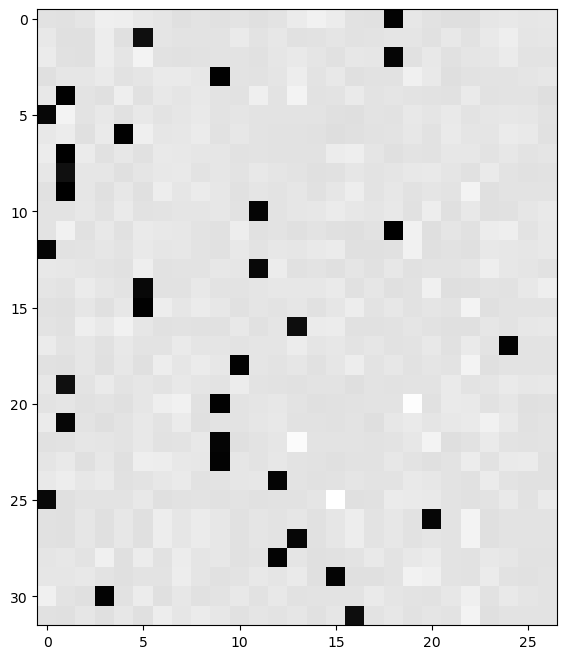

In [12]:
# What is dlogits? 
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
plt.imshow(dlogits.detach() , cmap = 'grey')

# It is sort of like a force which pulls the incorrect probabilities down proportional to the amount they are 
# incorrect by and it pushes up the correct probabilty equivalent to the sum of all these incorrect pulls 
# The net sum comes out to be zero for dlogits.

In [25]:
# Faster backprop for the batchnorm layer 

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())


# Manual fast backpropogation   

dhprebn = bngain*(bnvar_inv/n)*(n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact * bnraw).sum(0))
cmp('hprebn', dhprebn, hprebn)

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)
hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10
